# Práctica 3: Regresión Lineal, Regresión Logística y Árboles de Decisión

Esta práctica tiene tres grandes objetivos:
1. **Usar librería scikit-learn**: Aprenderemos a usar estos modelos usando esta librería.
2. **Modelos personalizados**: Aprenderemos a crear estos modelos "from scratch" e introduciremos algunas mejoras o implementaciones novedosas.
3. **Análisis de resultados**: Seremos capaces de ejecutar los modelos y entender y comprender los resultados, además de hacer un análisis de estos. 

# Librerías
Usaremos las siguientes librerías:

**RELLENAD**

In [18]:
#Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#Librerías sklearn y modelos
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#Librerías para preprocesado, particionado y métricas
from sklearn.model_selection import train_test_split, cross_val_predict,  KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score, confusion_matrix


# Cargado y preprocesing de los datos

Cargaremos los datos `train.csv` de la carpeta *data* y haremos el mismo preprocesing que en la anterior práctica: Cogeremos solo las columnas sin valores nulos y quitaremos las filas que tengan la variable Popularity vacía.

In [2]:
data = pd.read_csv('data/train.csv')
variables_regresion =['danceability','energy','loudness','mode','speechiness','acousticness','liveness','valence','tempo','duration_in min/ms','time_signature','Popularity']
variables_clasificacion = ['danceability','energy','loudness','mode','speechiness','acousticness','liveness','valence','tempo','duration_in min/ms','time_signature','Class']
data_regresion = data[variables_regresion]
data_clasificacion = data[variables_clasificacion]
data_regresion=data_regresion.dropna()
data_clasificacion=data_clasificacion.dropna()
#guardar csvs limpios
data_regresion.to_csv('data/data_regresion.csv', index=False)
data_clasificacion.to_csv('data/data_clasificacion.csv', index=False)

# Clases de métricas

## Diseño de la Clase `Metrics_Classification` para la Evaluación Centralizada:

Para gestionar y reportar consistentemente los resultados de las múltiples ejecuciones de los modelos y técnicas de validación, se ha diseñado la clase `Metrics_Classification`.

### Estructura y Funcionamiento

- Diccionario Central (`results = {}`):
    * Se define un diccionario a nivel de clase (`Metrics_Classification.results`) para actuar como un registro global centralizado.
    * Este diccionario almacena los resultados de cada instancia de evaluación (p. ej., "ZeroR Holdout simple", "KNN (k=5) Holdout 3", etc.) bajo una clave única (`validation_name`). Esto es crucial para la posterior agregación de métricas en los 10 Holdouts repetidos y en la Validación Cruzada.
- Métodos Individuales (`kappa`, `accuracy`, etc.):
    * Cada métrica se implementa en su propio método.
    * Para Precision, Recall y F1-Score, se utiliza el argumento `average='weighted'` para manejar correctamente el posible **desbalanceo de clases** en el conjunto de datos. (El desbalanceo de clases es un problema que surge en clasificación cuando las clases de destino no están distribuidas de manera uniforme)
- Método `all_metrics(self)` (Función Principal):
    1.  **Cálculo**: Llama a todos los métodos de métricas individuales para calcular los valores (`calculated_metrics`).
    2.  **Almacenamiento**: Almacena el diccionario completo de métricas (`calculated_metrics`) en el diccionario global `Metrics_Classification.results` utilizando `validation_name` como clave.
    3.  **Impresión**: Imprime las métricas con un formato limpio (4 decimales para métricas escalares) y la matriz de confusión en su formato original, proporcionando un *feedback* instantáneo y formateado de la ejecución.


In [6]:
class Metrics_Classification:
    # Diccionario a nivel de clase para almacenar todos los resultados de todas las ejecuciones
    results = {}

    def __init__(self, y_true, y_pred, validation_name):
        self.y_true = y_true
        self.y_pred = y_pred
        # Se añade el nombre de la validación para la clave del diccionario de resultados
        self.validation_name = validation_name

    def kappa(self):
        return cohen_kappa_score(self.y_true, self.y_pred)

    def accuracy(self):
        return accuracy_score(self.y_true, self.y_pred)

    def precision(self):
        # weighted para tener en cuenta el desbalanceo de clases
        # zero_division=0 para suprimir UndefinedMetricWarning
        return precision_score(self.y_true, self.y_pred, average='weighted', zero_division=0)

    def recall(self):
        # weighted para tener en cuenta el desbalanceo de clases
        # zero_division=0 para suprimir UndefinedMetricWarning
        return recall_score(self.y_true, self.y_pred, average='weighted', zero_division=0)

    def f1(self):
        # weighted para tener en cuenta el desbalanceo de clases
        # zero_division=0 para suprimir UndefinedMetricWarning
        return f1_score(self.y_true, self.y_pred, average='weighted', zero_division=0)

    def confusion_matrix(self):
        return confusion_matrix(self.y_true, self.y_pred)
    
    # Para obtener todas las métricas de una vez, imprimirlas y almacenarlas
    def all_metrics(self):
        # 1. Calcular todas las métricas
        calculated_metrics = {
            'Kappa': self.kappa(),
            'Accuracy': self.accuracy(),
            'Precision': self.precision(),
            'Recall': self.recall(),
            'F1 Score': self.f1(),
            'Confusion Matrix': self.confusion_matrix()
        }

        # 2. Almacenar las métricas en el diccionario de resultados de la clase
        Metrics_Classification.results[self.validation_name] = calculated_metrics

        # 3. Formatear e imprimir las métricas directamente (Nuevo formato)
        print(f"\n===== Resultados {self.validation_name} =====")
        for key, value in calculated_metrics.items():
            if key == 'Confusion Matrix':
                print(f'{key}:\n{value}')
            else:
                # Formato de 4 decimales
                print(f'{key}: {value:.4f}')



## Diseño de la Clase `Metrics` para la Evaluación Centralizada (Regresión)

Para gestionar y reportar de forma consistente los resultados de múltiples ejecuciones (distintas configuraciones de validación y modelos de **regresión**), se utiliza la clase `Metrics`.

### Estructura y funcionamiento

* **Diccionario central (`results = {}`)**

  * Se define un diccionario a nivel de clase (`Metrics.results`) como registro global centralizado.
  * Cada ejecución guarda sus resultados bajo una clave única `validation_name` (p. ej., `"ZeroR Holdout simple"`, `"KNN(k=5) CV-10fold"`, `"MyKNNRegressor (k=3) RepeatedKFold 5x2"`).
  * Esto permite la **agregación posterior** (p. ej., medias en 10 holdouts o evaluación global tras concatenar predicciones).

* **Métricas individuales (métodos)**

  * La clase implementa, cada una en su método, las métricas estándar de regresión:

    * `mse()` – Error cuadrático medio.
      $ \mathrm{MSE}=\frac{1}{n}\sum_{i=1}^{n}\big(y_i-\hat{y}_i\big)^2$

    * `mae()` – Error absoluto medio.
      $ \mathrm{MAE}=\frac{1}{n}\sum_{i=1}^{n}\big|y_i-\hat{y}_i\big|$

    * `rmse()` – Raíz del MSE.
      $ \mathrm{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}\big(y_i-\hat{y}_i\big)^2}$

    * `r2()` – Coeficiente de determinación.
      $ R^2=1-\frac{\sum_{i=1}^{n}\big(y_i-\hat{y}*i\big)^2}{\sum*{i=1}^{n}\big(y_i-\bar{y}\big)^2}$

    * `mape()` – Error porcentual absoluto medio.
      $ \mathrm{MAPE}(\%)=\frac{100}{n}\sum_{i=1}^{n}\left|\frac{y_i-\hat{y}_i}{,|y_i|+\varepsilon,}\right|)$

    * `rmspe()` – Raíz del error porcentual cuadrático medio.
      $ \mathrm{RMSPE}(\%)=100\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\frac{y_i-\hat{y}_i}{,|y_i|+\varepsilon,}\right)^2}$
  * Para evitar divisiones por cero en métricas porcentuales, la clase usa un **pequeño `eps`** (p. ej., `1e-12`) en los denominadores.

* **Normalización de entradas**

  * En el constructor, `y_true` y `y_pred` se convierten a `np.array` de tipo `float` y se aplastan a 1D, evitando problemas de tipos (Series/DataFrames) y garantizando cálculos consistentes.

* **Método principal `all_metrics(self)`**

  1. **Cálculo**: invoca todos los métodos y compone un diccionario `calculated_metrics` con `MSE`, `MAE`, `RMSE`, `R2`, `MAPE`, `RMSPE`.
  2. **Almacenamiento**: guarda `calculated_metrics` en `Metrics.results[validation_name]`.
  3. **Impresión**: muestra un resumen legible en consola (valores en notación decimal; `MAPE` y `RMSPE` en **%**).


In [7]:

class Metrics_Regression:
    # Diccionario a nivel de clase para almacenar todos los resultados de todas las ejecuciones
    results = {}

    def __init__(self, y_true, y_pred, validation_name, eps=1e-12):
        # Aseguramos arrays 1D float para evitar problemas de tipos/Series
        self.y_true = np.asarray(y_true, dtype=float).ravel()
        self.y_pred = np.asarray(y_pred, dtype=float).ravel()
        self.validation_name = validation_name
        self.eps = float(eps)

    # --- Métricas de regresión ---
    def mse(self):
        return mean_squared_error(self.y_true, self.y_pred)

    def mae(self):
        return mean_absolute_error(self.y_true, self.y_pred)

    def rmse(self):
        return np.sqrt(self.mse())

    def r2(self):
        return r2_score(self.y_true, self.y_pred)

    def mape(self):
        # *100 para porcentaje; eps evita divisiones por cero
        return np.mean(np.abs((self.y_true - self.y_pred) / (np.abs(self.y_true) + self.eps))) * 100.0

    def rmspe(self):
        return np.sqrt(np.mean(((self.y_true - self.y_pred) / (np.abs(self.y_true) + self.eps)) ** 2)) * 100.0

    # Para obtener todas las métricas de una vez, imprimirlas y almacenarlas
    def all_metrics(self):
        calculated_metrics = {
            'MSE': self.mse(),
            'MAE': self.mae(),
            'RMSE': self.rmse(),
            'R2': self.r2(),
            'MAPE': self.mape(),
            'RMSPE': self.rmspe()
        }

        # Guardar resultados
        Metrics_Regression.results[self.validation_name] = calculated_metrics

        # Imprimir con formato
        print(f"\n===== Resultados {self.validation_name} =====")
        for k, v in calculated_metrics.items():
            if k in ('MAPE', 'RMSPE'):
                print(f'{k}: {v:.4f}%')
            else:
                print(f'{k}: {v:.6f}')


# 1. Implementación Personalizada de los Modelos
En esta parte de la práctica diseñaremos *"from scratch"* los modelos de Regresión Lineal, Regresión Logística y Árboles de Decisión. Después haremos una evaluación de sus métricas haciendo una validación de 10 Holdout.

## Clase `myLinearRegression`

La clase implementa tres variantes del modelo de **regresión lineal**:
**OLS**, **Ridge**, y **AutoRidge**.
Todas comparten la misma estructura básica: estimar los coeficientes $\beta$ que mejor explican $y \approx X\beta + \beta_0$.

---

* **1. OLS (Ordinary Least Squares)**

**Objetivo:**
$$
\min_{\beta_0,\beta}||y - (\beta_0 + X\beta)||_2^2
$$

**Solución cerrada:**
$$
\hat{\theta} =
\begin{bmatrix}\hat{\beta}_0,\hat{\beta}\end{bmatrix}^T
(X^\top X)^{-1} X^\top y
$$

**Características algorítmicas:**

* Calcula la solución exacta mediante la ecuación normal.
* Sin ningún tipo de regularización.
* Puede ser inestable si las variables están muy correlacionadas (matriz (X^\top X) casi singular).

---

* **2. Ridge Regression (Regularización L2)**

**Objetivo:**
$$
\min_{\beta_0,\beta}; ||y - (\beta_0 + X\beta)||_2^2+\alpha ||\beta||_2^2
$$

**Solución analítica:**
$$
\hat{\theta}_{ridge} =
(X^\top X + \alpha D)^{-1} X^\top y
$$
donde $D = \mathrm{diag}(0,1,\dots,1)$ para **no penalizar el intercepto**.

**Características algorítmicas:**

* Introduce un término de penalización proporcional al cuadrado de los coeficientes.
* Atenúa la varianza y mejora la estabilidad numérica.
* El parámetro $\alpha$ controla el grado de encogimiento de los coeficientes.

---

* **3. AutoRidge (Regularización adaptativa y validación interna)**

**Objetivo:** aplicar una **penalización variable por característica** y encontrar de forma **automática** la intensidad óptima de regularización.

**Etapas algorítmicas**

1. **Penalización adaptativa por varianza**
   Cada coeficiente recibe un peso proporcional a la varianza de su variable:
   $$
   \lambda_j = \frac{\mathrm{Var}(X_j)}{\overline{\mathrm{Var}}}
   $$
   De esta forma, variables más dispersas se penalizan más.

2. **Rejilla de factores de regularización**
   Se prueban varios multiplicadores (k) alrededor de 1:
   $$
   k \in \{1-1.5\gamma, 1-\gamma, 1, 1+\gamma, 1+1.5\gamma\}
   $$
   donde $\gamma$ controla la amplitud de la búsqueda.

3. **Evaluación Leave-One-Out (LOO)**
   Para cada $k$, se calcula la matriz:
   $$
   A = X^\top X + kD
   \quad\text{y}\quad
   \hat{y} = X A^{-1} X^\top y
   $$
   Se estima el **error LOO** mediante:
   $$
   e_i^{LOO} = \frac{y_i - \hat{y}_i}{1 - h_{ii}},
   \qquad
   MSE_{LOO}(k) = \frac{1}{n}\sum_i (e_i^{LOO})^2
   $$
   El $k$ que minimiza $MSE_{LOO}$ se selecciona como óptimo.

4. **Reentrenamiento final**
   Se calcula el modelo definitivo con el mejor (k^*):
   $$
   \hat{\theta}_{final} = (X^\top X + k^* D)^{-1} X^\top y
   $$


In [8]:
class myLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, method="ols", alpha=1.0, gamma=0.1):
        self.method   = method
        self.alpha    = alpha
        self.gamma    = gamma
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1, 1)

        if self.method == 'ols':
            self._fit_ols_(X, y)
        elif self.method == 'ridge':
            self._fit_ridge_(X, y)
        elif self.method == 'autoridge':
            self._fit_autoridge_(X, y)
        else:
            raise ValueError(f"Método desconocido: {self.method}")

        return self 

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.coef_ + self.intercept_


    def _fit_ols_(self, X, y):
        X_ = np.hstack([np.ones((X.shape[0], 1)), X])
        XtX = X_.T @ X_
        Xty = X_.T @ y
        beta = np.linalg.inv(XtX) @ Xty
        self.intercept_ = float(beta[0, 0])
        self.coef_ = beta[1:, 0]

    def _fit_ridge_(self, X, y):
        X_ = np.hstack([np.ones((X.shape[0], 1)), X])
        XtX = X_.T @ X_
        Xty = X_.T @ y
        D = np.eye(X_.shape[1]); D[0, 0] = 0.0  # no penalizar intercepto
        beta = np.linalg.inv(XtX + self.alpha * D) @ Xty
        self.intercept_ = float(beta[0, 0])
        self.coef_ = beta[1:, 0]

    def _fit_autoridge_(self, X, y):
        # 1) penalización por varianza (intercepto no penalizado)
        n, p = X.shape
        X_  = np.hstack([np.ones((n, 1)), X])
        XtX = X_.T @ X_
        Xty = X_.T @ y

        var = X.var(axis=0) + 1e-12                 # (p,)
        base_lambdas = var / var.mean()             # media = 1
        D_base = np.diag(np.hstack(([0.0], base_lambdas)))  # (p+1,p+1)

        # 2) rejilla dependiendo de gamma
        k_grid = np.array([1 - 1.5*self.gamma, 1 - self.gamma,1, 1 + self.gamma, 1 + 1.5*self.gamma])

        best_k = None
        best_mse = np.inf

        for k in k_grid:
            A = XtX + k * D_base
            invA = np.linalg.inv(A)
            beta = invA @ Xty
            y_hat = X_ @ beta

            # 3) MSE LOO (PRESS): e_loo = (y - y_hat) / (1 - h_ii)
            H_diag = np.sum((X_ @ invA) * X_, axis=1)  # diag(X invA X^T)
            resid = (y - y_hat).ravel()
            e_loo = resid / (1.0 - H_diag + 1e-12)
            mse_loo = float(np.mean(e_loo**2))

            if mse_loo < best_mse:
                best_mse = mse_loo
                best_k = k
        # refit con el mejor k
        A = XtX + best_k * D_base
        beta = np.linalg.inv(A) @ Xty
        self.intercept_ = float(beta[0, 0])
        self.coef_ = beta[1:, 0]

### Validación

In [9]:
datos = pd.read_csv('data/data_regresion.csv')
# Dividimos los datos en 10 conjuntos de entrenamiento y pruebas
X = datos.drop('Popularity', axis=1)
y = datos['Popularity']
# 1. Inicializar listas para almacenar los 10 conjuntos
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# 2. Bucle para crear 10 divisiones y escalados diferentes
NUM_SPLITS = 10

for i in range(NUM_SPLITS):
    # a. División: Usamos 'i' como random_state para asegurar 10 divisiones distintas
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=i # CLAVE: Usar 'i' para tener 10 divisiones diferentes
    )
    
    # b. Estandarización
    scaler = StandardScaler()
    
    #  fit_transform en Train
    X_train_scaled = scaler.fit_transform(X_train_temp)
    
    # transform en Test (usando los parámetros aprendidos en Train)
    X_test_scaled = scaler.transform(X_test_temp)
    
    # c. Almacenar los resultados en las listas
    X_train_list.append(X_train_scaled)
    X_test_list.append(X_test_scaled)
    y_train_list.append(y_train_temp)
    y_test_list.append(y_test_temp)

In [10]:
for i in range(NUM_SPLITS):
    # a. Obtener los conjuntos de entrenamiento y prueba actuales
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]
    y_train_current = y_train_list[i]
    y_test_current = y_test_list[i]
    
    # b. Entrenar el regresor myLinearRegression
    lr = myLinearRegression(method='autoridge')
    lr.fit(X_train_current, y_train_current)
    y_pred_lr = lr.predict(X_test_current)
    

    # d. Metricas para el holdout actual
    metrics_10holdout_lr = Metrics_Regression(y_test_current, y_pred_lr, f'myLinearRegression Holdout {i+1}')
    metrics_10holdout_lr.all_metrics()


# Calcular las métricas promedio para los 10 holdouts de myLinearRegression
# Del diccionario results extraer las métricas y calcular la media para cada una
# MSE
all_mse = [Metrics_Regression.results[f'myLinearRegression Holdout {i+1}']['MSE'] for i in range(NUM_SPLITS)]
mse_mean_10holdout = np.mean(all_mse)
# MAE
all_mae = [Metrics_Regression.results[f'myLinearRegression Holdout {i+1}']['MAE'] for i in range(NUM_SPLITS)]
mae_mean_10holdout = np.mean(all_mae)
# RMSE
all_rmse = [Metrics_Regression.results[f'myLinearRegression Holdout {i+1}']['RMSE'] for i in range(NUM_SPLITS)]
rmse_mean_10holdout = np.mean(all_rmse)
# R2
all_r2 = [Metrics_Regression.results[f'myLinearRegression Holdout {i+1}']['R2'] for i in range(NUM_SPLITS)]
r2_mean_10holdout = np.mean(all_r2)
# MAPE
all_mape = [Metrics_Regression.results[f'myLinearRegression Holdout {i+1}']['MAPE'] for i in range(NUM_SPLITS)]
mape_mean_10holdout = np.mean(all_mape)
# RMSPE
all_rmspe = [Metrics_Regression.results[f'myLinearRegression Holdout {i+1}']['RMSPE'] for i in range(NUM_SPLITS)]
rmspe_mean_10holdout = np.mean(all_rmspe)


# Imprimir las métricas promedio
print('\n===== Métricas promedio myLinearRegression en 10 Holdouts =====')
print(f'MSE medio: {mse_mean_10holdout:.4f}')
print(f'MAE medio: {mae_mean_10holdout:.4f}')
print(f'RMSE medio: {rmse_mean_10holdout:.4f}')
print(f'R2 medio: {r2_mean_10holdout:.4f}')
print(f'MAPE medio: {mape_mean_10holdout:.4f}')
print(f'RMSPE medio: {rmspe_mean_10holdout:.4f}')


# 1. Crear el diccionario de resultados medios
mean_results = {
    'MSE':   mse_mean_10holdout,
    'MAE':   mae_mean_10holdout,
    'RMSE':  rmse_mean_10holdout,
    'R2':    r2_mean_10holdout,
    'MAPE':  mape_mean_10holdout,
    'RMSPE': rmspe_mean_10holdout
}

# 2. Guardar en Metrics_Regression.results con una clave única
Metrics_Regression.results['myLinearRegression_10_Holdouts_MEAN'] = mean_results


===== Resultados myLinearRegression Holdout 1 =====
MSE: 288.519704
MAE: 13.625248
RMSE: 16.985868
R2: 0.059034
MAPE: 74.8760%
RMSPE: 336.3711%

===== Resultados myLinearRegression Holdout 2 =====
MSE: 281.851256
MAE: 13.382222
RMSE: 16.788426
R2: 0.064059
MAPE: 67.7704%
RMSPE: 316.7773%

===== Resultados myLinearRegression Holdout 3 =====
MSE: 288.169869
MAE: 13.625127
RMSE: 16.975567
R2: 0.057240
MAPE: 66.6737%
RMSPE: 295.2974%

===== Resultados myLinearRegression Holdout 4 =====
MSE: 285.000948
MAE: 13.481417
RMSE: 16.881971
R2: 0.049871
MAPE: 65.8968%
RMSPE: 280.1466%

===== Resultados myLinearRegression Holdout 5 =====
MSE: 288.118659
MAE: 13.612079
RMSE: 16.974058
R2: 0.053591
MAPE: 71.0002%
RMSPE: 309.9980%

===== Resultados myLinearRegression Holdout 6 =====
MSE: 288.024679
MAE: 13.535088
RMSE: 16.971290
R2: 0.058894
MAPE: 74.6303%
RMSPE: 323.7021%

===== Resultados myLinearRegression Holdout 7 =====
MSE: 286.002955
MAE: 13.562946
RMSE: 16.911622
R2: 0.053914
MAPE: 65.8628%
RM

### Interpretación de resultados

## Clase `myLogisticRegression`

La clase implementa un modelo de **regresión logística multiclase**, siguiendo exactamente la *generalización multinomial One-vs-All implícita* presentada en la teoría.

El objetivo es estimar la probabilidad de que una observación pertenezca a una de las $J$ clases posibles, modelando esta probabilidad mediante funciones logísticas y optimizando los parámetros con **descenso del gradiente** sobre la entropía cruzada multiclase.

---

1. **Modelo Multiclase (One-vs-All implícito)**

A diferencia del modelo binario, donde solo existe un vector de pesos $w$, en el caso multiclase se define un vector para cada clase excepto la última:

$$
w_1, w_2, \dots, w_{J-1}
$$

Cada vector modela la contribución lineal:

$$
z_{ij} = w_j^\top x_i
$$

donde $x_i$ incluye un primer componente igual a 1 (bias).

---

**2. Probabilidades de clase**

La generalización del Tema 6 utiliza el siguiente esquema:

- Para las clases $1,\dots,J-1$:

$$
p_{ij} = 
\frac{\exp(w_j^\top x_i)}
{1 + \sum_{m=1}^{J-1}\exp(w_m^\top x_i)}
$$

- Para la última clase $J$:

$$
p_{iJ} = 1 - \sum_{j=1}^{J-1} p_{ij}
$$

Esta formulación garantiza que:

$$
\sum_{j=1}^{J} p_{ij} = 1
$$

y evita tener que definir un vector de pesos explícito para la última clase.

---

**3. Función de pérdida: entropía cruzada multiclase**

Sea $Y$ la matriz *one-hot* donde:

- $Y_{ij} = 1$ si la muestra $i$ pertenece a la clase $j$
- $0$ en caso contrario

La pérdida es:

$$
E = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^J Y_{ij} \log(p_{ij})
$$

---

**4. Gradiente**

El gradiente respecto a cada vector de pesos $w_j$, para $j = 1,\dots,J-1$, viene dado por:
$$
\frac{\partial E}{\partial w_j}=
\frac{1}{N}
\sum_{i=1}^N (p_{ij} - Y_{ij}) x_i
$$
De esta forma, todos los vectores se actualizan simultáneamente en cada iteración.

---

**5. Regla de actualización**

Usando descenso del gradiente con tasa de aprendizaje $\eta$:

$$
w_j \leftarrow w_j - \eta \, \frac{\partial E}{\partial w_j}
$$

Solo se actualizan los pesos de las primeras $J-1$ clases, ya que la clase restante está implícita.

---

**6. Predicción**

Para un nuevo vector $x$:

1. Se calculan las probabilidades generalizadas $p_{ij}$
2. Se selecciona la clase con mayor probabilidad:

$$
\hat{y} = \arg\max_j \, p_{ij}
$$

---

**7. Resumen de características del clasificador**

* Modelo multinomial con $J-1$ vectores de pesos.
* Probabilidades consistentes con la formulación del Tema 6.
* Optimización mediante **descenso del gradiente batch**.
* Compatible con scikit-learn (hereda de `BaseEstimator` y `ClassifierMixin`).
* Implementación totalmente vectorizada.


In [12]:
class myLogisticRegression(BaseEstimator, ClassifierMixin):

    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.W_ = None
        self.classes_ = None

    def _softmax_generalized(self, Z):
        """
        Z tiene dimensión (N, J-1).
        Implementa EXACTAMENTE la generalización del Tema 6:

            p_j = exp(z_j) / (1 + sum_m exp(z_m))   para j = 1..J-1
            p_J = 1 - sum_j p_j

        Devuelve probas de dimensión (N, J).
        """
        expZ = np.exp(Z)
        denom = 1 + np.sum(expZ, axis=1, keepdims=True)
        P_small = expZ / denom               # p1..p(J-1)
        p_last = 1 - np.sum(P_small, axis=1, keepdims=True)
        return np.hstack([P_small, p_last])

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()

        N, k = X.shape
        self.classes_ = np.unique(y)
        J = len(self.classes_)

        # Matriz X con bias
        Xb = np.hstack([np.ones((N, 1)), X])   # (N, k+1)

        # ONE-HOT de y → matriz Y (N, J)
        Y = np.zeros((N, J))
        for idx, c in enumerate(self.classes_):
            Y[y == c, idx] = 1

        # W tendrá dimensión (k+1, J-1)
        rng = np.random.default_rng()
        self.W_ = rng.uniform(-0.01, 0.01, size=(k+1, J-1))

        prev_loss = np.inf

        for _ in range(self.max_iter):

            # Forward → Z = XW (N × (J-1))
            Z = Xb.dot(self.W_)

            # Probabilidades generalizadas (Tema 6, pág. 54)
            P = self._softmax_generalized(Z)  # (N, J)

            # Cross-entropy multiclase
            loss = -np.mean(np.sum(Y * np.log(P + 1e-12), axis=1))

            # Gradiente: dE/dW_j para j=1..J-1
            # Solo actualizamos hasta J-1 (la última clase es implícita)
            error = (P - Y)[:, :J-1]           # (N, J-1)
            grad = Xb.T.dot(error) / N        # (k+1, J-1)

            # Descenso del gradiente
            self.W_ -= self.learning_rate * grad

            # Criterio de parada
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss

        return self

    def predict(self, X):
        X = np.asarray(X)
        Xb = np.hstack([np.ones((X.shape[0], 1)), X])

        Z = Xb.dot(self.W_)                  # (N, J-1)
        P = self._softmax_generalized(Z)     # (N, J)

        preds_idx = np.argmax(P, axis=1)
        return self.classes_[preds_idx]

### Validación

In [14]:
datos = pd.read_csv('data/data_clasificacion.csv')
# Dividimos los datos en 10 conjuntos de entrenamiento y pruebas
X = datos.drop('Class', axis=1)
y = datos['Class']
# 1. Inicializar listas para almacenar los 10 conjuntos
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# 2. Bucle para crear 10 divisiones y escalados diferentes
NUM_SPLITS = 10

for i in range(NUM_SPLITS):
    # a. División: Usamos 'i' como random_state para asegurar 10 divisiones distintas
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=i # CLAVE: Usar 'i' para tener 10 divisiones diferentes
    )
    
    # b. Estandarización
    scaler = StandardScaler()
    
    #  fit_transform en Train
    X_train_scaled = scaler.fit_transform(X_train_temp)
    
    # transform en Test (usando los parámetros aprendidos en Train)
    X_test_scaled = scaler.transform(X_test_temp)
    
    # c. Almacenar los resultados en las listas
    X_train_list.append(X_train_scaled)
    X_test_list.append(X_test_scaled)
    y_train_list.append(y_train_temp)
    y_test_list.append(y_test_temp)


In [ ]:
# ZeroR para los 10 holdouts

precisiones_Log_r = []

for i in range(NUM_SPLITS):
    # a. Obtener los conjuntos de entrenamiento y prueba actuales
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]
    y_train_current = y_train_list[i]
    y_test_current = y_test_list[i]
    

    # b. LogisticRegression
    Log_r = myLogisticRegression(learning_rate=0.05,max_iter=5000,tol=1e-6)
    Log_r.fit(X_train_current, y_train_current)
    y_pred_Log_r = Log_r.predict(X_test_current)
    precision_current = np.mean(y_pred_Log_r == y_test_current)

    # c. Almacenar la precisión en la lista
    precisiones_Log_r.append(precision_current)

    # d. Metricas para el holdout actual
    metrics_10holdout_Log_r = Metrics_Classification(y_test_current, y_pred_Log_r, f'myLogisticRegression Holdout {i+1}')
    metrics_10holdout_Log_r.all_metrics()



# Calcular las métricas promedio para los 10 holdouts de LogisticRegression

# Del diccionario results extraer las métricas y calcular la media para cada una
# Kappa
all_kappas = [Metrics_Classification.results[f'myLogisticRegression Holdout {i+1}']['Kappa'] for i in range(NUM_SPLITS)]
kappa_mean_10holdout = np.mean(all_kappas)
# Accuracy
all_accuracies = [Metrics_Classification.results[f'myLogisticRegression Holdout {i+1}']['Accuracy'] for i in range(NUM_SPLITS)]
accuracy_mean_10holdout = np.mean(all_accuracies)
# Precision
all_precisions = [Metrics_Classification.results[f'myLogisticRegression Holdout {i+1}']['Precision'] for i in range(NUM_SPLITS)]
precision_mean_10holdout = np.mean(all_precisions)
# Recall
all_recalls = [Metrics_Classification.results[f'myLogisticRegression Holdout {i+1}']['Recall'] for i in range(NUM_SPLITS)]
recall_mean_10holdout = np.mean(all_recalls)
# F1 Score
all_f1_scores = [Metrics_Classification.results[f'myLogisticRegression Holdout {i+1}']['F1 Score'] for i in range(NUM_SPLITS)]
f1_mean_10holdout = np.mean(all_f1_scores)

# Matriz agregada
confusion_matrices = [Metrics_Classification.results[f'myLogisticRegression Holdout {i+1}']['Confusion Matrix'] for i in range(NUM_SPLITS)]
aggregated_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Imprimir las métricas promedio
print('\n===== Métricas promedio myLogisticRegression en 10 Holdouts =====')
print(f'Kappa medio: {kappa_mean_10holdout:.4f}')
print(f'Accuracy medio: {accuracy_mean_10holdout:.4f}')
print(f'Precision media: {precision_mean_10holdout:.4f}')
print(f'Recall medio: {recall_mean_10holdout:.4f}')
print(f'F1 Score medio: {f1_mean_10holdout:.4f}')
print(f'Matriz de confusión agregada:\n{aggregated_confusion_matrix}')

# 1. Crear el diccionario de resultados medios
mean_results = {
    'Kappa': kappa_mean_10holdout,
    'Accuracy': accuracy_mean_10holdout,
    'Precision': precision_mean_10holdout,
    'Recall': recall_mean_10holdout,
    'F1 Score': f1_mean_10holdout,
    'Confusion Matrix': aggregated_confusion_matrix,
}

# 2. Guardar el diccionario de resultados medios en Metrics_Classification.results con una clave única
Metrics_Classification.results['myLogisticRegression_10_Holdouts_MEAN'] = mean_results



===== Resultados LogisticRegression Holdout 1 =====
Kappa: 0.3606
Accuracy: 0.4685
Precision: 0.4205
Recall: 0.4685
F1 Score: 0.4320
Confusion Matrix:
[[104   0   0   8  14   0   0  29   0  12   0]
 [  0   0  11   0   0  18  45   3  22  43 196]
 [  0   0  84   0   0   5  32   2  10  61 134]
 [ 15   0   0  65   9   0   0   8   0   4   0]
 [ 24   0   0   6  48   0   0   4   0  11   0]
 [  0   0  10   1   0 240  20   1   4  86  23]
 [  1   0  28   0   0  39  72   7  45  92 340]
 [  9   0   0   4   1   0   0 131   0   3   0]
 [  0   0   1   0   0   0   5   0 238   3 195]
 [ 33   0  31   6  13  52  24   1   2 325 174]
 [ 11   0  43   5  18  11  79   3 126 115 801]]

===== Resultados LogisticRegression Holdout 2 =====
Kappa: 0.3562
Accuracy: 0.4668
Precision: 0.4252
Recall: 0.4668
F1 Score: 0.4319
Confusion Matrix:
[[115   0   0   9  17   0   0   9   0  19   1]
 [  0   0   8   0   0  24  34   4  21  47 184]
 [  0   0  82   1   0   7  40   2   5  57 148]
 [ 13   0   0  64   6   2   0   7   0

KeyboardInterrupt: 

### Interpretación de resultados

## Clase `myDecisionTreeClassifier`

El modelo soporta dos criterios de partición:
- $\textbf{ID3}$: utiliza la entropía y la ganancia de información.
- $\textbf{Gini}$: utiliza el índice de Gini y la reducción de impureza.

El constructor del modelo:

```python
MyDecisionTreeClassifier(criterio="gini", 
                         max_depth=None, 
                         min_samples_split=2)
```

Define los siguientes hiperparámetros:

- `criterio`: puede ser \texttt{"id3"} o \texttt{"gini"}.  
    - Si es $\texttt{"id3"}$, el modelo usa entropía y ganancia de información
        como en ID3.
    - Si es $\texttt{"gini"}$, utiliza el índice Gini característico de CART.

- `max_depth`: profundización máxima del árbol, 
    implementando pre-poda.
    
- `min_samples_split`: tamaño mínimo de un nodo para poder dividirse.
    


En ID3 original no existe poda, pero el temario recomienda técnicas 
de pre-poda para evitar sobreajuste.

---
* **Criterios**

1. **Entropía (ID3)**

La función:

```python
def entropy(self, y):
    ...
```

implementa exactamente la definición teórica:

$$
H(C) = -\sum_{i=1}^{K} p(C_i)\,\log_2 p(C_i),
$$
Esto quiere decir:
- $H(C)=0$ si el nodo es puro,
- $H(C)$ es máxima cuando las clases están uniformemente distribuidas.

2. **Gini**

La función:

```python
def gini(self, y):
    ...
```

implementa la fórmula teórica del índice Gini:

$$
Gini(T) = 1 - \sum_{i=1}^{K} p_i^2,
$$

El índice Gini es cero cuando todas las instancias pertenecen a la misma clase.

---

* **Ganancia de Información / Reducción de Impureza**

La función:

```python
information_gain(self, y, y_left, y_right, impurity_func)
```
calcula la mejora de impureza producida al dividir un nodo en dos subconjuntos.

Sea $T$ el nodo padre y $T_L$, $T_R$ los nodos hijos.
$$
\begin{align}
\text{Gain} &= 
\text{Impureza}(T) \;-\;
\left(
    \frac{|T_L|}{|T|} \text{Impureza}(T_L)
    +
    \frac{|T_R|}{|T|} \text{Impureza}(T_R)
\right)
\end{align}
$$

- Con entropía, esto coincide exactamente con la $\textbf{Ganancia de Información}$:
    $$
    I(C,X) = H(C) - H(C \mid X)
    $$
- Con Gini, coincide con la $\textbf{reducción de impureza de CART}$.

---
* **Selección del Mejor Punto de Corte**

La función:

```python
best_split(self, X, y)
```

evalúa todas las características y todos los posibles umbrales para encontrar la partición que maximiza la ganancia.


1. Ordenar los valores del atributo.
    \item Calcular puntos medios entre valores consecutivos:
    $$
        t_j = \frac{v_j + v_{j+1}}{2}.
    $$
2. Evaluar los splits binarios:
    $$
        X_i < t_j \qquad \text{y} \qquad X_i \ge t_j.
    $$
3.  Seleccionar el umbral que maximiza la reducción de impureza.



La función devuelve:
- el índice de la mejor característica;
- el mejor umbral encontrado.

Si ningún split mejora la impureza, se devuelve $\texttt{None}$ y el nodo se convertirá en hoja.

---

* **Construcción Recursiva del Árbol**

La función:

```python
build_tree(self, X, y, depth)
```

implementa el algoritmo recursivo para ID3 y CART:

1. Crear un nodo con la clase mayoritaria.
2. Comprobar condiciones de parada:
    - nodo puro ,
    - profundidad máxima alcanzada (pre-poda),
    - tamaño mínimo insuficiente (pre-poda).
3. Buscar el mejor split mediante `best_split`.
    \item Si existe un split válido:
    - asignar atributo y umbral al nodo,
    - dividir los datos en hijos izquierdo y derecho,
    - llamar recursivamente al método para construir subárboles.

--- 
* **Predicción**

La predicción se realiza mediante un recorrido desde la raíz hasta una hoja:

- En cada nodo interno se evalúa la condición:
    $$
        x[\text{feature}] \le \text{threshold}.
    $$
- Se sigue la rama correspondiente.
- Al alcanzar un nodo hoja, se devuelve la clase almacenada.


In [29]:
class myDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, criterio="gini", max_depth=None, min_samples_split=2):
        self.criterion = criterio
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree_ = None # Almacenará el árbol de decisión entrenado

    # Criterios

    # Gini
    def gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return 1.0 - np.sum(p**2)

    # ID3
    def entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return -np.sum(p * np.log2(p + 1e-12)) # Se añade un valor pequeño para evitar el log(0)

    def information_gain(self, y, y_left, y_right, impurity_func):
        # Seleccionar el atributo que produzca la mayor reducción de la entropía de la clase después de la partición
        impurity_parent = impurity_func(y)
        n = len(y)
        n_left, n_right = len(y_left), len(y_right)
        
        if n_left == 0 or n_right == 0:
            return 0.0

        impurity_children = (n_left / n) * impurity_func(y_left) + \
                            (n_right / n) * impurity_func(y_right)

        gain = impurity_parent - impurity_children
        return gain

    def best_split(self, X, y):
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split: # No dividir si no hay más del mínimo de muestras
            return None, None
        
        # Elige la función de impureza
        if self.criterion.lower() == "id3":
            impurity_func = self.entropy
        elif self.criterion.lower() == "gini":
            impurity_func = self.gini
        
        best_gain = -np.inf
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(n_features):
            # valores ordenados de la característica
            x_column = X[:, feature_idx]
            # valores candidatos (puntos medios entre valores únicos)
            unique_vals = np.unique(x_column)
            if len(unique_vals) == 1:
                continue  # no se puede dividir si todo es igual
            
            # candidatos tipo sklearn: puntos medios
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0
            
            for threshold in thresholds:
                left_mask = x_column <= threshold
                right_mask = ~left_mask
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                gain = self.information_gain(y, y_left, y_right, impurity_func)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        if best_gain <= 0:
            return None, None
        
        return best_feature, best_threshold

    # Construcción del árbol
    def build_tree(self, X, y, depth):
        # Nodo hoja si: puro, max_depth alcanzada o muy pocas muestras
        num_samples = len(y)
        unique_classes, counts = np.unique(y, return_counts=True)
        majority_class = unique_classes[np.argmax(counts)]
        
        node = {
            "is_leaf": False,
            "prediction": majority_class,
            "feature_index": None,
            "threshold": None,
            "left": None,
            "right": None
        }
        
        # criterios de parada
        if len(unique_classes) == 1:  # todas las etiquetas iguales
            node["is_leaf"] = True
            return node
        
        if self.max_depth is not None and depth >= self.max_depth:
            node["is_leaf"] = True
            return node
        
        if num_samples < self.min_samples_split:
            node["is_leaf"] = True
            return node
        
        # buscar mejor split
        feature_idx, threshold = self.best_split(X, y)
        
        if feature_idx is None:  # no mejora
            node["is_leaf"] = True
            return node
        
        # crear hijos
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        node["feature_index"] = feature_idx
        node["threshold"] = threshold
        node["left"] = self.build_tree(X_left, y_left, depth + 1)
        node["right"] = self.build_tree(X_right, y_right, depth + 1)
        
        return node

    # Funciones fit() y predict()
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.tree_ = self.build_tree(X, y, depth=0)
        return self
    
    def predict_one(self, x, node):
        if node["is_leaf"]:
            return node["prediction"]
        
        if x[node["feature_index"]] <= node["threshold"]:
            return self.predict_one(x, node["left"])
        else:
            return self.predict_one(x, node["right"])
    
    def predict(self, X):
        X = np.asarray(X)
        return np.array([self.predict_one(x, self.tree_) for x in X])

### Validación

In [30]:
datos = pd.read_csv('data/data_clasificacion.csv')
# Dividimos los datos en 10 conjuntos de entrenamiento y pruebas
X = datos.drop('Class', axis=1)
y = datos['Class']
# 1. Inicializar listas para almacenar los 10 conjuntos
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# 2. Bucle para crear 10 divisiones y escalados diferentes
NUM_SPLITS = 10

for i in range(NUM_SPLITS):
    # a. División: Usamos 'i' como random_state para asegurar 10 divisiones distintas
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=i # CLAVE: Usar 'i' para tener 10 divisiones diferentes
    )
    
    # b. Estandarización
    scaler = StandardScaler()
    
    #  fit_transform en Train
    X_train_scaled = scaler.fit_transform(X_train_temp)
    
    # transform en Test (usando los parámetros aprendidos en Train)
    X_test_scaled = scaler.transform(X_test_temp)
    
    # c. Almacenar los resultados en las listas
    X_train_list.append(X_train_scaled)
    X_test_list.append(X_test_scaled)
    y_train_list.append(y_train_temp)
    y_test_list.append(y_test_temp)


In [31]:
# Decision Tree para los 10 holdouts

precisiones_dt = []

for i in range(NUM_SPLITS):
    # a. Obtener los conjuntos de entrenamiento y prueba actuales
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]
    y_train_current = y_train_list[i]
    y_test_current = y_test_list[i]
    

    # b. Decision Tree
    dt = myDecisionTreeClassifier(criterio="gini", max_depth=10, min_samples_split=2)
    dt.fit(X_train_current, y_train_current)
    y_pred_dt = dt.predict(X_test_current)
    precision_current = np.mean(y_pred_dt == y_test_current)

    # c. Almacenar la precisión en la lista
    precisiones_dt.append(precision_current)

    # d. Metricas para el holdout actual
    metrics_10holdout_dt = Metrics_Classification(y_test_current, y_pred_dt, f'myDecisionTree Holdout {i+1}')
    metrics_10holdout_dt.all_metrics()



# Calcular las métricas promedio para los 10 holdouts de myDecisionTree

# Del diccionario results extraer las métricas y calcular la media para cada una
# Kappa
all_kappas = [Metrics_Classification.results[f'myDecisionTree Holdout {i+1}']['Kappa'] for i in range(NUM_SPLITS)]
kappa_mean_10holdout = np.mean(all_kappas)
# Accuracy
all_accuracies = [Metrics_Classification.results[f'myDecisionTree Holdout {i+1}']['Accuracy'] for i in range(NUM_SPLITS)]
accuracy_mean_10holdout = np.mean(all_accuracies)
# Precision
all_precisions = [Metrics_Classification.results[f'myDecisionTree Holdout {i+1}']['Precision'] for i in range(NUM_SPLITS)]
precision_mean_10holdout = np.mean(all_precisions)
# Recall
all_recalls = [Metrics_Classification.results[f'myDecisionTree Holdout {i+1}']['Recall'] for i in range(NUM_SPLITS)]
recall_mean_10holdout = np.mean(all_recalls)
# F1 Score
all_f1_scores = [Metrics_Classification.results[f'myDecisionTree Holdout {i+1}']['F1 Score'] for i in range(NUM_SPLITS)]
f1_mean_10holdout = np.mean(all_f1_scores)

# Matriz agregada
confusion_matrices = [Metrics_Classification.results[f'myDecisionTree Holdout {i+1}']['Confusion Matrix'] for i in range(NUM_SPLITS)]
aggregated_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Imprimir las métricas promedio
print('\n===== Métricas promedio myDecisionTree en 10 Holdouts =====')
print(f'Kappa medio: {kappa_mean_10holdout:.4f}')
print(f'Accuracy medio: {accuracy_mean_10holdout:.4f}')
print(f'Precision media: {precision_mean_10holdout:.4f}')
print(f'Recall medio: {recall_mean_10holdout:.4f}')
print(f'F1 Score medio: {f1_mean_10holdout:.4f}')
print(f'Matriz de confusión agregada:\n{aggregated_confusion_matrix}')

# 1. Crear el diccionario de resultados medios
mean_results = {
    'Kappa': kappa_mean_10holdout,
    'Accuracy': accuracy_mean_10holdout,
    'Precision': precision_mean_10holdout,
    'Recall': recall_mean_10holdout,
    'F1 Score': f1_mean_10holdout,
    'Confusion Matrix': aggregated_confusion_matrix,
}

# 2. Guardar el diccionario de resultados medios en Metrics_Classification.results con una clave única
Metrics_Classification.results['myDecisionTree_10_Holdouts_MEAN'] = mean_results



===== Resultados myDecisionTree Holdout 1 =====
Kappa: 0.3210
Accuracy: 0.4403
Precision: 0.4211
Recall: 0.4403
F1 Score: 0.4123
Confusion Matrix:
[[ 94   0   0  16  20   0   0  22   0  12   3]
 [  0   6   7   0   0  12  60   0  12  39 202]
 [  0   0  51   0   0   3  42   0   5  37 190]
 [ 21   0   0  58   8   0   0   6   0   5   3]
 [ 17   0   0   8  55   0   0   3   0   8   2]
 [  0   6  10   0   0 217  33   0   3  75  41]
 [  0  19  16   0   0  21 101   0  22 104 341]
 [ 14   0   0   7   1   0   0 123   0   2   1]
 [  0   2   2   0   0   1   6   0 208   1 222]
 [ 19   5  14   6  24  52  74   4   1 257 205]
 [ 12   7  34   3  13   9  92   0 107 124 811]]

===== Resultados myDecisionTree Holdout 2 =====
Kappa: 0.3364
Accuracy: 0.4557
Precision: 0.4400
Recall: 0.4557
F1 Score: 0.4260
Confusion Matrix:
[[106   0   0  15  24   0   0  11   0  10   4]
 [  0   2   5   0   0  10  49   0   9  60 187]
 [  0   2  67   0   0   6  31   0   2  49 185]
 [ 19   0   0  58   4   0   0  14   0   2   2

KeyboardInterrupt: 

### Interpretación de resultados

## Conclusión

# 2. Análisis de Árboles durante el Entrenamiento

# 3. Análisis en la Validación y Optimización de Hiperparámetros

# 4. Ejecución de los Modelos de Clasificación

# 5. Ejecución de los Modelos de Regresión

In [19]:
datos = pd.read_csv('data/data_regresion.csv')

## Hold out simple

In [20]:
# Dividimos los datos en conjunto de entrenamiento y prueba
X = datos.drop('Popularity', axis=1)
y = datos['Popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Linear Regression

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
metrics_lr = Metrics_Regression(y_test, y_pred_lr, 'LinearRegression Holdout simple')
metrics_lr.all_metrics()


===== Resultados LinearRegression Holdout simple =====
MSE: 283.877226
MAE: 13.426346
RMSE: 16.848656
R2: 0.065825
MAPE: 71.8222%
RMSPE: 310.8880%


### Decision Tree Regressor

In [22]:
dtr = DecisionTreeRegressor(min_samples_leaf=1, ccp_alpha=0.0, random_state=42)
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)
metrics_dtr = Metrics_Regression(y_test, y_pred_dtr, 'DecisionTreeRegressor Holdout simple')
metrics_dtr.all_metrics()


===== Resultados DecisionTreeRegressor Holdout simple =====
MSE: 461.807377
MAE: 15.711976
RMSE: 21.489704
R2: -0.519702
MAPE: 67.9508%
RMSPE: 290.2679%


## 10 Holdout repetidos 75-25

In [23]:
# Dividimos los datos en 10 conjuntos de entrenamiento y pruebas

# 1. Inicializar listas para almacenar los 10 conjuntos
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# 2. Bucle para crear 10 divisiones y escalados diferentes
NUM_SPLITS = 10

for i in range(NUM_SPLITS):
    # a. División: Usamos 'i' como random_state para asegurar 10 divisiones distintas
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=i # CLAVE: Usar 'i' para tener 10 divisiones diferentes
    )
    
    # b. Estandarización
    scaler = StandardScaler()
    
    #  fit_transform en Train
    X_train_scaled = scaler.fit_transform(X_train_temp)
    
    # transform en Test (usando los parámetros aprendidos en Train)
    X_test_scaled = scaler.transform(X_test_temp)
    
    # c. Almacenar los resultados en las listas
    X_train_list.append(X_train_scaled)
    X_test_list.append(X_test_scaled)
    y_train_list.append(y_train_temp)
    y_test_list.append(y_test_temp)

 

### Linear Regresion

In [24]:
for i in range(NUM_SPLITS):
    # a. Obtener los conjuntos de entrenamiento y prueba actuales
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]
    y_train_current = y_train_list[i]
    y_test_current = y_test_list[i]
    
    # b. Entrenar el regresor LinearRegression
    lr = LinearRegression()
    lr.fit(X_train_current, y_train_current)
    y_pred_lr = lr.predict(X_test_current)
    

    # d. Metricas para el holdout actual
    metrics_10holdout_lr = Metrics_Regression(y_test_current, y_pred_lr, f'LinearRegression Holdout {i+1}')
    metrics_10holdout_lr.all_metrics()


# Calcular las métricas promedio para los 10 holdouts de LinearRegression

# Del diccionario results extraer las métricas y calcular la media para cada una
# MSE
all_mse = [Metrics_Regression.results[f'LinearRegression Holdout {i+1}']['MSE'] for i in range(NUM_SPLITS)]
mse_mean_10holdout = np.mean(all_mse)
# MAE
all_mae = [Metrics_Regression.results[f'LinearRegression Holdout {i+1}']['MAE'] for i in range(NUM_SPLITS)]
mae_mean_10holdout = np.mean(all_mae)
# RMSE
all_rmse = [Metrics_Regression.results[f'LinearRegression Holdout {i+1}']['RMSE'] for i in range(NUM_SPLITS)]
rmse_mean_10holdout = np.mean(all_rmse)
# R2
all_r2 = [Metrics_Regression.results[f'LinearRegression Holdout {i+1}']['R2'] for i in range(NUM_SPLITS)]
r2_mean_10holdout = np.mean(all_r2)
# MAPE
all_mape = [Metrics_Regression.results[f'LinearRegression Holdout {i+1}']['MAPE'] for i in range(NUM_SPLITS)]
mape_mean_10holdout = np.mean(all_mape)
# RMSPE
all_rmspe = [Metrics_Regression.results[f'LinearRegression Holdout {i+1}']['RMSPE'] for i in range(NUM_SPLITS)]
rmspe_mean_10holdout = np.mean(all_rmspe)


# Imprimir las métricas promedio
print('\n===== Métricas promedio LinearRegression en 10 Holdouts =====')
print(f'MSE medio: {mse_mean_10holdout:.4f}')
print(f'MAE medio: {mae_mean_10holdout:.4f}')
print(f'RMSE medio: {rmse_mean_10holdout:.4f}')
print(f'R2 medio: {r2_mean_10holdout:.4f}')
print(f'MAPE medio: {mape_mean_10holdout:.4f}')
print(f'RMSPE medio: {rmspe_mean_10holdout:.4f}')


# 1. Crear el diccionario de resultados medios
mean_results = {
    'MSE':   mse_mean_10holdout,
    'MAE':   mae_mean_10holdout,
    'RMSE':  rmse_mean_10holdout,
    'R2':    r2_mean_10holdout,
    'MAPE':  mape_mean_10holdout,
    'RMSPE': rmspe_mean_10holdout
}

# 2. Guardar en Metrics_Regression.results con una clave única
Metrics_Regression.results['LinearRegression_10_Holdouts_MEAN'] = mean_results




===== Resultados LinearRegression Holdout 1 =====
MSE: 288.519944
MAE: 13.625251
RMSE: 16.985875
R2: 0.059033
MAPE: 74.8759%
RMSPE: 336.3728%

===== Resultados LinearRegression Holdout 2 =====
MSE: 281.851387
MAE: 13.382224
RMSE: 16.788430
R2: 0.064059
MAPE: 67.7704%
RMSPE: 316.7796%

===== Resultados LinearRegression Holdout 3 =====
MSE: 288.170784
MAE: 13.625138
RMSE: 16.975594
R2: 0.057237
MAPE: 66.6737%
RMSPE: 295.2983%

===== Resultados LinearRegression Holdout 4 =====
MSE: 285.001991
MAE: 13.481445
RMSE: 16.882002
R2: 0.049867
MAPE: 65.8967%
RMSPE: 280.1469%

===== Resultados LinearRegression Holdout 5 =====
MSE: 288.119232
MAE: 13.612096
RMSE: 16.974075
R2: 0.053589
MAPE: 71.0001%
RMSPE: 309.9992%

===== Resultados LinearRegression Holdout 6 =====
MSE: 288.024352
MAE: 13.535077
RMSE: 16.971280
R2: 0.058895
MAPE: 74.6297%
RMSPE: 323.6979%

===== Resultados LinearRegression Holdout 7 =====
MSE: 286.004660
MAE: 13.562987
RMSE: 16.911672
R2: 0.053908
MAPE: 65.8629%
RMSPE: 277.1906%

### Decision Tree Regressor

In [25]:
for i in range(NUM_SPLITS):
    # a. Obtener los conjuntos de entrenamiento y prueba actuales
    X_train_current = X_train_list[i]
    X_test_current = X_test_list[i]
    y_train_current = y_train_list[i]
    y_test_current = y_test_list[i]
    
    # b. Entrenar el regresor LinearRegression
    dtr = DecisionTreeRegressor(min_samples_leaf=1, ccp_alpha=0.0, random_state=42)
    dtr.fit(X_train_current, y_train_current)
    y_pred_dtr = dtr.predict(X_test_current)
    

    # d. Metricas para el holdout actual
    metrics_10holdout_dtr = Metrics_Regression(y_test_current, y_pred_dtr, f'DecisionTreeRegressor Holdout {i+1}')
    metrics_10holdout_dtr.all_metrics()


# Calcular las métricas promedio para los 10 holdouts de DecisionTreeRegressor

# Del diccionario results extraer las métricas y calcular la media para cada una
# MSE
all_mse = [Metrics_Regression.results[f'DecisionTreeRegressor Holdout {i+1}']['MSE'] for i in range(NUM_SPLITS)]
mse_mean_10holdout = np.mean(all_mse)
# MAE
all_mae = [Metrics_Regression.results[f'DecisionTreeRegressor Holdout {i+1}']['MAE'] for i in range(NUM_SPLITS)]
mae_mean_10holdout = np.mean(all_mae)
# RMSE
all_rmse = [Metrics_Regression.results[f'DecisionTreeRegressor Holdout {i+1}']['RMSE'] for i in range(NUM_SPLITS)]
rmse_mean_10holdout = np.mean(all_rmse)
# R2
all_r2 = [Metrics_Regression.results[f'DecisionTreeRegressor Holdout {i+1}']['R2'] for i in range(NUM_SPLITS)]
r2_mean_10holdout = np.mean(all_r2)
# MAPE
all_mape = [Metrics_Regression.results[f'DecisionTreeRegressor Holdout {i+1}']['MAPE'] for i in range(NUM_SPLITS)]
mape_mean_10holdout = np.mean(all_mape)
# RMSPE
all_rmspe = [Metrics_Regression.results[f'DecisionTreeRegressor Holdout {i+1}']['RMSPE'] for i in range(NUM_SPLITS)]
rmspe_mean_10holdout = np.mean(all_rmspe)


# Imprimir las métricas promedio
print('\n===== Métricas promedio DecisionTreeRegressor en 10 Holdouts =====')
print(f'MSE medio: {mse_mean_10holdout:.4f}')
print(f'MAE medio: {mae_mean_10holdout:.4f}')
print(f'RMSE medio: {rmse_mean_10holdout:.4f}')
print(f'R2 medio: {r2_mean_10holdout:.4f}')
print(f'MAPE medio: {mape_mean_10holdout:.4f}')
print(f'RMSPE medio: {rmspe_mean_10holdout:.4f}')


# 1. Crear el diccionario de resultados medios
mean_results = {
    'MSE':   mse_mean_10holdout,
    'MAE':   mae_mean_10holdout,
    'RMSE':  rmse_mean_10holdout,
    'R2':    r2_mean_10holdout,
    'MAPE':  mape_mean_10holdout,
    'RMSPE': rmspe_mean_10holdout
}

# 2. Guardar en Metrics_Regression.results con una clave única
Metrics_Regression.results['DecisionTreeRegressor_10_Holdouts_MEAN'] = mean_results




===== Resultados DecisionTreeRegressor Holdout 1 =====
MSE: 463.388832
MAE: 15.648338
RMSE: 21.526468
R2: -0.511277
MAPE: 75.9244%
RMSPE: 332.3872%

===== Resultados DecisionTreeRegressor Holdout 2 =====
MSE: 455.473247
MAE: 15.531193
RMSE: 21.341819
R2: -0.512486
MAPE: 70.5520%
RMSPE: 346.4822%

===== Resultados DecisionTreeRegressor Holdout 3 =====
MSE: 473.242758
MAE: 15.787758
RMSE: 21.754143
R2: -0.548234
MAPE: 68.7294%
RMSPE: 327.4808%

===== Resultados DecisionTreeRegressor Holdout 4 =====
MSE: 469.345116
MAE: 15.821835
RMSE: 21.664374
R2: -0.564691
MAPE: 69.6581%
RMSPE: 287.0299%

===== Resultados DecisionTreeRegressor Holdout 5 =====
MSE: 464.234403
MAE: 15.780510
RMSE: 21.546099
R2: -0.524912
MAPE: 70.7434%
RMSPE: 326.8275%

===== Resultados DecisionTreeRegressor Holdout 6 =====
MSE: 458.165775
MAE: 15.584358
RMSE: 21.404807
R2: -0.497033
MAPE: 69.7821%
RMSPE: 290.6350%

===== Resultados DecisionTreeRegressor Holdout 7 =====
MSE: 482.356374
MAE: 16.038669
RMSE: 21.962613
R2:

## Validación cruzada de 5 particiones (5-Fold Cross-Validation)

In [26]:
scaler = StandardScaler()

X_crossval = scaler.fit_transform(X)

# Cross-Validation de 5 particiones (5-Fold Cross-Validation):
LinearRegression = cross_val_predict(LinearRegression(), X_crossval, y, cv=5)

DecisionTreeRegressor = cross_val_predict(DecisionTreeRegressor(min_samples_leaf=1, ccp_alpha=0.0, random_state=42), X_crossval, y, cv=5)

# Metricas:

# LinearRegression
metrics_LinearRegression_CV = Metrics_Regression(y, LinearRegression, 'LinearRegression 5-Fold CV')
metrics_LinearRegression_CV.all_metrics()

# DecisionTreeRegressor
metrics_DecisionTreeRegressor_CV = Metrics_Regression(y, DecisionTreeRegressor, 'DecisionTreeRegressor 5-Fold CV')
metrics_DecisionTreeRegressor_CV.all_metrics()



===== Resultados LinearRegression 5-Fold CV =====
MSE: 284.975755
MAE: 13.503948
RMSE: 16.881225
R2: 0.061594
MAPE: 69.4220%
RMSPE: 303.6416%

===== Resultados DecisionTreeRegressor 5-Fold CV =====
MSE: 461.188653
MAE: 15.543232
RMSE: 21.475303
R2: -0.518664
MAPE: 69.3121%
RMSPE: 306.8724%


## Interpretación de resultados
* **Comparación de resultados**
Para poder comparar los modelos haremos uso de dos tipos de gráficas distintas con los datos guardados en la clase propia `Metrics`
1. **Gráfico de barras**: Sencillo de entender y fácil de interpretar. Habrá que tener cuidado ya que, a diferencia de la clasificación, queremos estas barras sean bajas, ya que queremos minimizar los errores (exceptuando el $R^2$ que queremos que sea máximo).
2. **HeatMap**: para poder comparar y poder elegir el mejor modelo según las métricas.

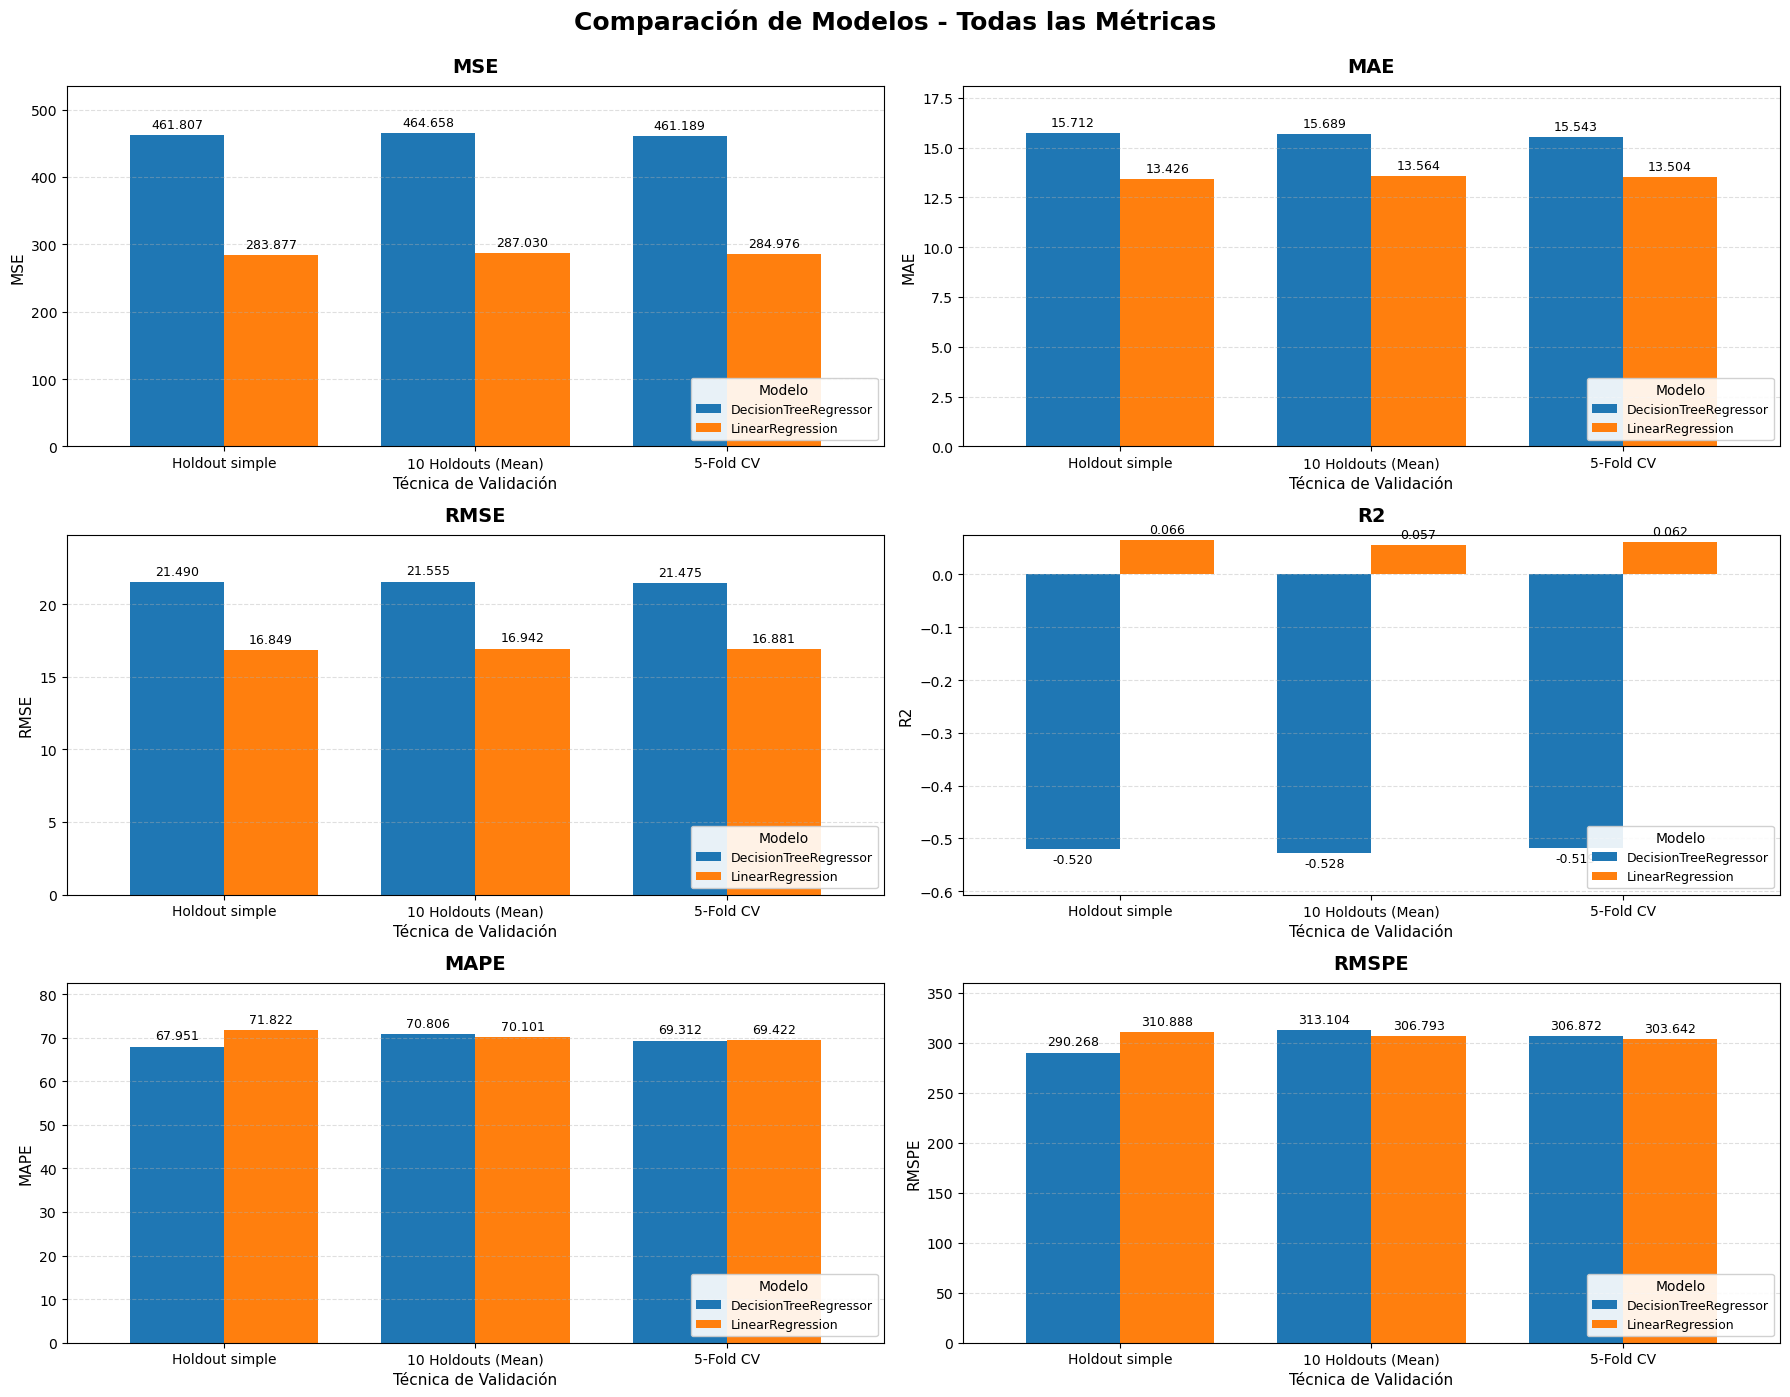

In [28]:
filtered_results = {
    key: metrics
    for key, metrics in Metrics_Regression.results.items()
    if not any(f"Holdout {i}" in key for i in range(1, 11))  # excluye Holdout 1..10
    and not key.startswith("my")                              # excluye todo lo que empiece por "my"
}

# 2. Procesar datos
parsed_data = []
for key, metrics in filtered_results.items():
    if 'Holdout simple' in key:
        validation, model = 'Holdout simple', key.replace(' Holdout simple', '')
    elif '_10_Holdouts_MEAN' in key:
        validation, model = '10 Holdouts (Mean)', key.replace('_10_Holdouts_MEAN', '')
    elif '5-Fold CV' in key:
        validation = '5-Fold CV'
        model = key.replace(' 5-Fold CV', '')
    else:
        continue
    
    parsed_data.append({
        'Model': model,
        'Validation': validation,
        **{m: metrics.get(m, np.nan) for m in ['MSE', 'MAE', 'RMSE', 'R2', 'MAPE', 'RMSPE']}
    })

df_results = pd.DataFrame(parsed_data)

# 3. Configuración de visualización
metrics = ['MSE', 'MAE', 'RMSE', 'R2', 'MAPE', 'RMSPE']
validation_order = ['Holdout simple', '10 Holdouts (Mean)', '5-Fold CV']
model_order = sorted(df_results['Model'].unique(), key=lambda x: ('KNN' in x, x))

# 4. Crear subplots
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Pivotar datos
    df_pivot = df_results.pivot(index='Validation', columns='Model', values=metric)
    df_pivot = df_pivot.reindex(validation_order)[model_order]
    
    # Graficar barras
    df_pivot.plot(kind='bar', ax=ax, width=0.75, rot=0)
    
    # Añadir valores sobre las barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9)
    
    # Configuración
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel(metric, fontsize=11)
    ax.set_xlabel('Técnica de Validación', fontsize=11)
    ax.legend(title='Modelo', loc='lower right', fontsize=9, framealpha=0.9)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    # Ajustar límites Y
    min_val = df_pivot.min().min()
    max_val = df_pivot.max().max()
    ax.set_ylim([min(0, min_val * 1.15), max_val * 1.15])



plt.suptitle('Comparación de Modelos - Todas las Métricas', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()